## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn   
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchsummary import summary
import nibabel as nib
from tqdm import tqdm
import torch.nn.functional as F

c:\Users\el debs\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparing data

In [14]:
# constants
base_directory = './data/'
train_patient_list = os.listdir(base_directory + 'train/')
test_patient_list = os.listdir(base_directory + 'test/')

train_patient_list = train_patient_list[: len(train_patient_list)]
test_patient_list = test_patient_list[: len(test_patient_list)]

slices_per_patient = 96
num_slices_selected = 3

In [15]:
class BratsDataset(Dataset):
    def __init__(self, mode, transform=None):
        super(BratsDataset, self).__init__()
        self.mode = mode
        self.transform = transform
        self.patient_list = train_patient_list if mode == 'train' else test_patient_list
        self.directory = base_directory + mode + '/'

        self.x = []
        for patient in tqdm(self.patient_list):
            self.x.append(
                np.stack([
                    nib.load(self.directory + patient + '/' + patient + '_best_slices/' + patient + '_flair' + '.nii.gz').get_fdata()
                ], axis=-1)

                # for mri_type in ['_flair', '_seg', '_t1', '_t1ce', '_t2']
            )
        self.x = np.stack(self.x, axis=0)

    def __len__(self):
        return len(self.patient_list)

    def get_data(self):
        return self.x

    def __getitem__(self, idx):
        # pour avoir l'idx d'un patient
        sequence = self.x[idx]

        # standardize the sequence
        sequence = torch.Tensor(cv.normalize(sequence.transpose(2, 0, 1), None, 0, 1, cv.NORM_MINMAX))

        # on normalise les images
        if self.transform:
            sequence = self.transform(sequence)
            sequence_other = self.transform(sequence_other)

        return sequence

In [16]:
train_dataset = BratsDataset('train', transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 200/200 [00:00<00:00, 472.30it/s]


In [17]:
test_dataset = BratsDataset('test', transform=None)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

100%|██████████| 50/50 [00:00<00:00, 396.50it/s]


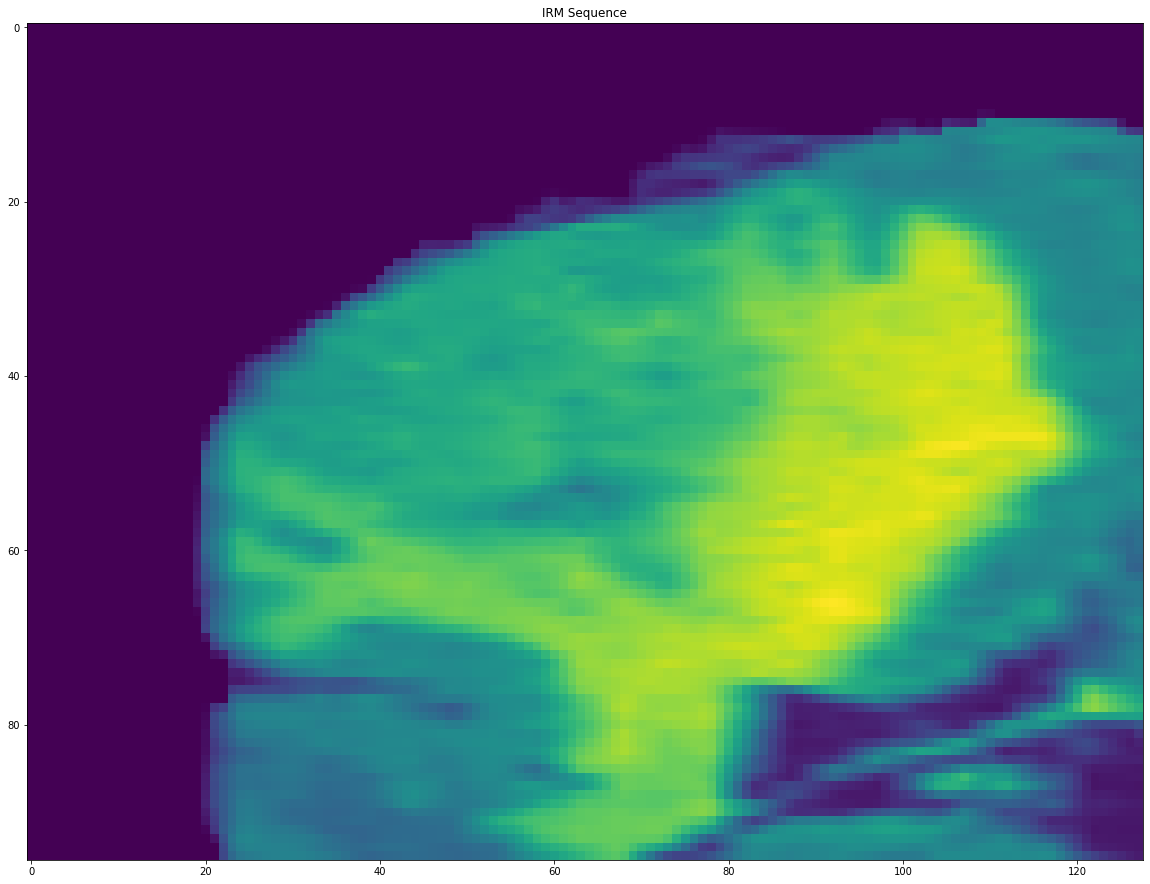

In [18]:
def show_irm(irm):
    irm[:] *= 90  # random constant just to make the plot more visible
    irm = irm.transpose(2, 0, 1)
    irm = np.hstack([s for s in irm])
    plt.figure(figsize=(20, 20))
    plt.title('IRM Sequence')
    plt.imshow(irm)

show_irm(train_dataset.x[np.random.randint(0, len(train_dataset))])

### Defining model

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [20]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

      return loss_contrastive

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.Flatten(),
            nn.Linear(256 * 3 * 4, self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 256 * 3 * 4),
            nn.Unflatten(1, (256, 3, 4)),
            nn.ConvTranspose2d(self.latent_dim, 256, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def train_reconstruction(self, loader, epochs=10, lr=0.001):
        self.to(device)
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            for i, x in enumerate(loader):
                x = x.to(device)
                optimizer.zero_grad()
                x_reconstructed = self.forward(x)
                loss = criterion(x_reconstructed, x)
                loss.backward()
                optimizer.step()
                if i % 100 == 0:
                    print(f"Epoch {epoch}, batch {i}/{len(loader)}, loss {loss.item()}")

summary(Autoencoder().to(device), (1, 96, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Conv2d: 2-1                       [-1, 32, 48, 64]          320
|    └─LeakyReLU: 2-2                    [-1, 32, 48, 64]          --
|    └─BatchNorm2d: 2-3                  [-1, 32, 48, 64]          64
|    └─Conv2d: 2-4                       [-1, 64, 24, 32]          18,496
|    └─LeakyReLU: 2-5                    [-1, 64, 24, 32]          --
|    └─BatchNorm2d: 2-6                  [-1, 64, 24, 32]          128
|    └─Conv2d: 2-7                       [-1, 128, 12, 16]         73,856
|    └─LeakyReLU: 2-8                    [-1, 128, 12, 16]         --
|    └─BatchNorm2d: 2-9                  [-1, 128, 12, 16]         256
|    └─Conv2d: 2-10                      [-1, 256, 6, 8]           295,168
|    └─LeakyReLU: 2-11                   [-1, 256, 6, 8]           --
|    └─BatchNorm2d: 2-12                 [-1, 256, 6, 8]           51

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Conv2d: 2-1                       [-1, 32, 48, 64]          320
|    └─LeakyReLU: 2-2                    [-1, 32, 48, 64]          --
|    └─BatchNorm2d: 2-3                  [-1, 32, 48, 64]          64
|    └─Conv2d: 2-4                       [-1, 64, 24, 32]          18,496
|    └─LeakyReLU: 2-5                    [-1, 64, 24, 32]          --
|    └─BatchNorm2d: 2-6                  [-1, 64, 24, 32]          128
|    └─Conv2d: 2-7                       [-1, 128, 12, 16]         73,856
|    └─LeakyReLU: 2-8                    [-1, 128, 12, 16]         --
|    └─BatchNorm2d: 2-9                  [-1, 128, 12, 16]         256
|    └─Conv2d: 2-10                      [-1, 256, 6, 8]           295,168
|    └─LeakyReLU: 2-11                   [-1, 256, 6, 8]           --
|    └─BatchNorm2d: 2-12                 [-1, 256, 6, 8]           51

In [ ]:
ae = Autoencoder().to(device)
ae.train_reconstruction(train_loader, epochs=300, lr=0.001)

In [ ]:
seg = Autoencoder().to(device)
seg.train_reconstruction(train_loader, epochs=300, lr=0.001)

In [ ]:
t1 = Autoencoder().to(device)
t1.train_reconstruction(train_loader, epochs=300, lr=0.001)

In [ ]:
t1ce = Autoencoder().to(device)
t1ce.train_reconstruction(train_loader, epochs=300, lr=0.001)

In [ ]:
t2 = Autoencoder().to(device)
t2.train_reconstruction(train_loader, epochs=300, lr=0.001)

## Visual comparison of the results 

In [25]:
# we keep sample indexes to plot the results, for visual comparison
signatures = []
indexes = np.random.randint(0, len(train_dataset), size=100)
for i in indexes:
    x = train_dataset[i].to(device)
    x_latent = ae.encode(x.expand(1, 1, 96, 128))
    x_latent = x_latent.detach().cpu().numpy()
    signatures.append(x_latent)

distance_matrix = np.zeros((100, 100))
for i in range(10):
    for j in range(10):
        distance_matrix[i, j] = np.linalg.norm(signatures[i] - signatures[j])

query_idx = np.random.randint(0, 10)
query_original_idx = indexes[query_idx]

most_similar_idx = np.argsort(distance_matrix[query_idx])[:3] # les 3 premiers
most_similar_original_idx = indexes[most_similar_idx]

most_dissimilar_idx = np.argsort(distance_matrix[query_idx])[-3:] # les 3 derniers
most_dissimilar_original_idx = indexes[most_dissimilar_idx]

torch.Size([1, 96, 128])
tensor([[[0.4099, 0.3474, 0.2921,  ..., 0.0000, 0.0000, 0.0000],
         [0.3314, 0.3285, 0.2907,  ..., 0.0000, 0.0000, 0.0000],
         [0.2979, 0.2893, 0.2732,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])


NameError: name 'ae' is not defined

In [ ]:
# distances
distance_matrix[query_idx, most_similar_idx], distance_matrix[query_idx, most_dissimilar_idx]

#### Query IRM

In [ ]:
show_irm(train_dataset.x[query_original_idx])

#### 3 Most similar IRMs

In [ ]:
for i in most_similar_original_idx:
    show_irm(train_dataset.x[i])

### 3 Most dissimilar IRMs

In [ ]:
for i in most_dissimilar_original_idx:
    show_irm(train_dataset.x[i])

# Saving and loading model

##### 1. Save

In [ ]:
torch.save(ae, 'ae.pth')
print('model saved')

In [9]:
torch.save(t1, 't1.pth')
print('model saved')

NameError: name 't1' is not defined

In [10]:
torch.save(t1ce, './models/t1ce.pth')
print('model saved')

NameError: name 't1ce' is not defined

In [ ]:
torch.save(t2, 't2.pth')
print('model saved')

In [ ]:
torch.save(seg, 'seg.pth')
print('model saved')

##### 2. Load

In [21]:
flair = torch.load('./models/model.pth', map_location=torch.device('cpu'))
# ne pas oublier car j'utilise un batchNorm
flair.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): 

In [24]:
for i, x in enumerate(test_loader):
    print (flair.encode(x).shape)

RuntimeError: Given groups=1, weight of size [32, 5, 3, 3], expected input[50, 1, 96, 128] to have 5 channels, but got 1 channels instead